In [1]:
%load_ext autoreload
%autoreload 2

import wandb_util.wandb_util as wbu

runs = wbu.get_logged_runs("prove_artefacts_stormtrooper")

In [2]:
from omegaconf import OmegaConf
from scripts.wandb_runs.run_generative_rendering import RunGenerativeRenderingConfig
from text3d2video.util import group_into_array


def scene_key(run):
    config: RunGenerativeRenderingConfig = OmegaConf.create(run.config)
    return config.animation_tag


def method_key(run):
    config: RunGenerativeRenderingConfig = OmegaConf.create(run.config)
    if config.generative_rendering.do_pre_attn_injection:
        return "GR"
    else:
        return "ControlNet"


runs_grouped, labels = group_into_array(runs, key_funs=[scene_key, method_key])

In [3]:
from text3d2video.experiment_analysis import GrData
from text3d2video.util import map_array

# Read run data
run_data = map_array(runs_grouped, GrData.from_gr_run, pbar=True)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


(3, 4)


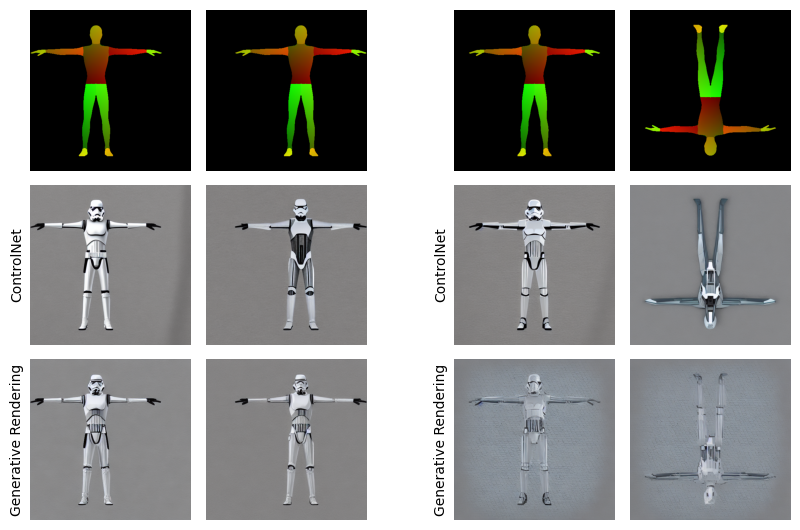

In [115]:
from text3d2video.util import object_array
from text3d2video.utilities.ipython_utils import display_ims, display_ims_grid
import numpy as np
from text3d2video.utilities.matplotlib_utils import add_zoom_inset
from matplotlib.transforms import Bbox


def scene_grid(scene):
    uvs = scene[0].uvs
    controlnet = scene[0].frames
    generative_rendering = scene[1].frames
    return object_array([uvs, controlnet, generative_rendering])


scene_1 = run_data[0, :]
scene_2 = run_data[1, :]

grid_1 = scene_grid(scene_1)
grid_2 = scene_grid(scene_2)

grid_all = np.hstack([grid_1, grid_2])

fig, axs = display_ims_grid(grid_all, scale=1.8, show=False)

labels = ["", "ControlNet", "Generative Rendering"]
ylabel_cols = [0, 2]

for col_i in ylabel_cols:
    col = axs[:, col_i]
    for i, ax in enumerate(col):
        ax.set_ylabel(labels[i])

for idx in [2, 3]:
    col_axes = axs[:, idx]
    for ax in col_axes:
        pos = ax.get_position()  # Bbox: [x0, y0, width, height]
        new_pos = [pos.x0 + 0.1, pos.y0, pos.width, pos.height]  # shift right
        ax.set_position(new_pos)


ax = axs[1, 2]

print(axs.shape)

frame_1_scene_1 = axs[1:, 0]
frame_2_scene_1 = axs[1:, 1]
frame_1_scene_2 = axs[1:, 2]
frame_2_scene_2 = axs[1:, 3]

w = 100
box_1_scene_1 = Bbox.from_bounds(160, 30, w, w)
box_2_scene_1 = Bbox.from_bounds(250, 30, w, w)

box_1_scene_2 = Bbox.from_bounds(205, 30, w, w)
box_2_scene_2 = Bbox.from_bounds(205, 375, w, w)

axs_and_box = [
    (frame_1_scene_1, box_1_scene_1),
    (frame_2_scene_1, box_2_scene_1),
    (frame_1_scene_2, box_1_scene_2),
    (frame_2_scene_2, box_2_scene_2),
]

# for axs, box in axs_and_box:
#     for ax in axs:
#         add_zoom_inset(ax, box)

# box = Bbox.from_bounds(100, 100, 100, 100)

# add_zoom_inset(ax, box)

fig.savefig("outs/prove_artefacts.pdf", bbox_inches="tight", dpi=300)

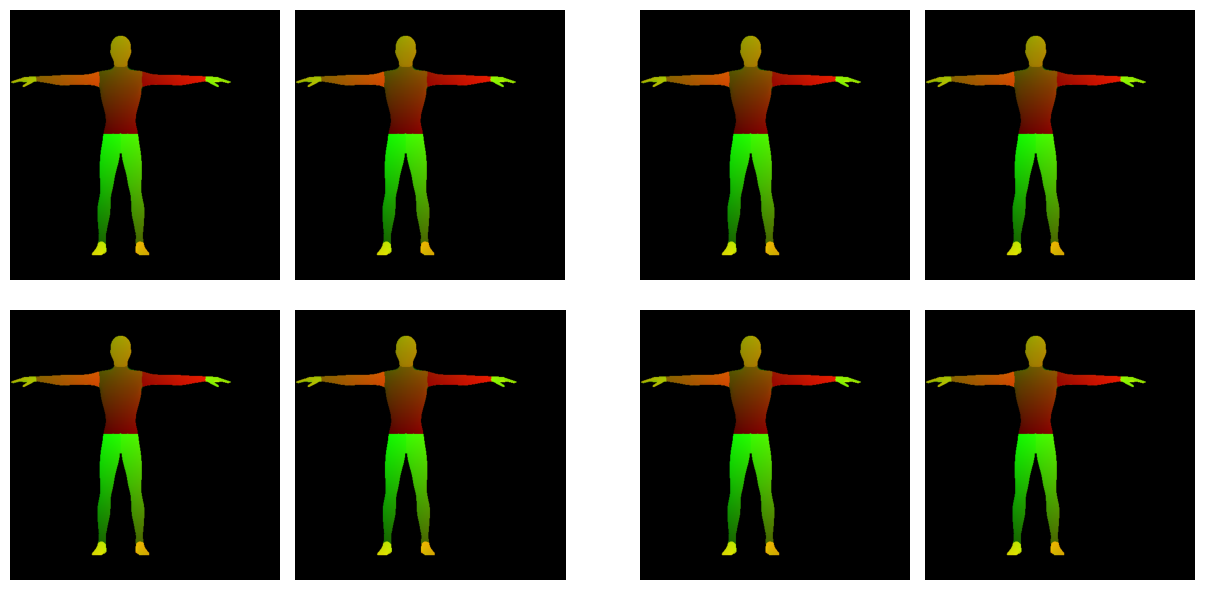

In [58]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 6))

# Parameters
nrows = 2
ncols = 4
gap = 0.05  # horizontal gap between col 1 and 2

# Width of one image and spacing
image_width = (1.0 - gap) / 4

image = grid_all[0, 0]

axes = []
for i in range(nrows):
    for j in range(ncols):
        # Add gap after second column (between col 1 and 2, index 1 and 2)
        extra_gap = gap if j >= 2 else 0
        left = j * image_width + extra_gap
        bottom = 1.0 - (i + 1) * 0.5  # vertical placement
        ax = fig.add_axes([left, bottom, image_width, 0.45])
        ax.imshow(image)
        ax.axis("off")
        axes.append(ax)

plt.show()